# TUTORIAL 5: 𝑷𝒓𝒐𝒈𝒓𝒆𝒔𝒔𝒊𝒗𝒆 𝑮𝒓𝒐𝒘𝒊𝒏𝒈 𝒐𝒇 𝑮𝑨𝑵𝒔
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed **Pytorch** and **Augmentare** properly.

This tutorial uses the highly popular 𝑷𝒓𝒐𝒈𝒓𝒆𝒔𝒔𝒊𝒗𝒆 𝑮𝒓𝒐𝒘𝒊𝒏𝒈 𝒐𝒇 𝑮𝑨𝑵𝒔 or **ProGAN** architecture. **Augmentare** provides a generalised implementation of **ProGAN**.

**Paper** - [Progressive Growing of GANs for Improved Quality, Stability, and Variation by Tero Karras & al.](https://arxiv.org/abs/1710.10196)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Pytorch and Torchvision Imports
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Augmentare Imports
import augmentare
from augmentare.methods.gan import *
from augmentare.plots.plot_losses import plot_losses_gan
from augmentare.plots.plot_samples import plot_image

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eb911jag because the default path (/home/vuong.nguyen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING

This tutorial uses the **Celeb_HQ** dataset for illustration purposes. We apply the following transformations to the raw dataset to speed up training:

1. For the purposes of this tutorial, we resize the images to $256$ and then we use RandomHorizontalFlip.

2. The images are normalized with a mean and standard deviation of 0.5 for each channel. This has been observed to enable easier training (one can also choose to normalize with the per channel mean and standard deviation).

We then wrap the dataset in a **DataLoader**. Because in the following sections, said **DataLoader** is required to be passed as a parameter while training.

In [4]:
image_size = 256

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])  

dataset = dsets.ImageFolder('/home/vuong.nguyen/vuong/data-augmentation-fairness/data/Celeb_HQ', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

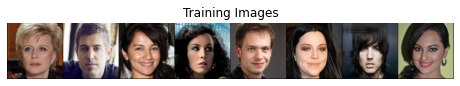

In [5]:
#Plot some training images 
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## NETWORK ARCHITECTURE : ProGAN

Progressive Growing GAN also known as ProGAN is an extension of the GAN training process that allows training generating models with stability that can produce large-high-quality images.

It involves training by starting with a very small image and then layer blocks are added gradually so that the output size of the generator model increases and the input size of the discriminator model increases until the desired image size is obtained. This approach has proven to be very effective in creating highly realistic, high-quality synthetic images.

It basically includes 4 steps:
- Progressive growing (of model and layers)

- Minibatch std on Discriminator

- Normalization with PixelNorm

 - Equalized Learning Rate

<div class=figure>
  <p align="center" width="100%"> <img width="50%" src="/home/vuong.nguyen/vuong/augmentare/docs/assets/progan.gif">
  <p align="center">
</div>

Here we can see in the above figure that Progressive Growing GAN involves using a generator and discriminator model with the traditional GAN structure and its starts with very small images, such as 4×4 pixels.

During training, it systematically adds new convolutional blocks to both the generator model and the discriminator model. This gradual addition of convolutional layers allows models to effectively learn coarse-level details early on and then learn even finer details, both on the generator and discriminator.

**ProGAN goals:**
- Produce high-quality, high-resolution images.
- Greater diversity of images in the output.
- Improve stability in GANs.
- Increase variation in the generated images

#### ProGAN Generator

A generator to incrementally size the output by starting with a very small image, then the blocks of layers added incrementally and increasing the input size of the discriminant model until the desired image size is obtained.

Hyperparameters:

`latent_size:` Size of latent vector (i.e size of generator input)

`in_channels:` In channels

`img_channels:` Number of channels in the training images

In [6]:
net_gen = PROGANGenerator(
    latent_size=128,
    in_channels=128,
    img_channels=3,
    alpha=1e-5,
    steps=4
)

#### ProGAN Discriminator

A discriminator for discerning real from generated images.

Hyperparameters:

`in_channels:` In channels

`img_channels:` Number of channels in the training images

In [7]:
net_dis = PROGANDiscriminator(
    in_channels=128,
    img_channels=3,
    alpha=1e-5,
    steps=4
)

## OPTIMIZERS AND LOSS FUNCTIONS

ProGAN use one of the common loss functions in GANs, the **Wasserstein** loss function, also known as **WGAN-GP** from the paper [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf?ref=blog.paperspace.com). 

$$Loss_{G} = -D(x')$$
$$GP = (||\nabla D(ax' + (1-a)x))||_2 - 1)^2$$
$$Loss_{D} = -D(x) + D(x') + \lambda * GP$$

Where:
- x' is the generated image.
- x is an image from the training set.
- D is the discriminator.
- GP is a gradient penalty that helps stabilize training.
- The a term in the gradient penalty refers to a tensor of random numbers between 0 and 1, chosen uniformly at random.
- The parameter λ is common to set to 10.

#### Other Parameters (optimizer, loss function)

**Adam** optimizer is often used to train neural networks, it usually avoids the need for hyperparameter search on parameters like learning rate, etc. **Adam** has hyperparameters that usually don't require much tuning:

-`Learning rate:` or step size. The weightes are updated (e.g. 0.001). A larger value (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values ​​(eg: 1.0e-5) slow down the learning right during training. Here we set $lr=0.0001$

-`Beta1:` Exponential decay rate for the first time estimate. Here we set $0.0$

-`Beta2:` Exponentially decay rate for second time estimates. This value should be set close to $1.0$ for problems with sparse gradients (e.g. NLP and computer vision problems). Hence we set $0.999$ 

We use this **GradScaler** functions if the device is cuda. 


In [8]:
optimizer_gen = Adam(net_gen.parameters(), lr=1e-3, betas=(0.0, 0.999))
optimizer_dis = Adam(net_dis.parameters(), lr=1e-3, betas=(0.0, 0.999))
loss_fn_gen =  torch.cuda.amp.GradScaler()
loss_fn_dis =  torch.cuda.amp.GradScaler()

#### Create your GAN object

A basic ProGAN class for generating images.

Parameters:

`generator:` A torch DCGAN Generator architecture

`discriminator:` A torch DCGAN Discriminator architecture

`optimizer_gen:` An optimizer for generator

`optimizer_dis:` An optimizer for discriminator

`loss_fn_gen:` A loss function for generator

`loss_fn_dis:` A loss function for discriminator

`device:` Cpu or CUDA

`latent_size:` Size of latent vector (i.e size of generator input)

In [9]:
# Create GAN network
gan = PROGAN(
    net_gen,
    net_dis,
    optimizer_gen,
    optimizer_dis,
    loss_fn_gen,
    loss_fn_dis,
    device,
    latent_size=128
)

## TRAINING THE DCGAN NETWORK

Training the model is quite expensive. Hence, we will train models for 10 epochs if GPU is available, otherwise we will train only for 5 epochs. We should change **num_epochs** so that the model learns to generate good quality images.

In [10]:
gen_losses, dis_losses = gan.train(
    subset_a=dataloader,
    num_epochs=5,
    num_decay_epochs=None,
    num_classes = None,
    batch_size = [32, 32, 32, 16, 16, 16, 16, 8, 4],
    subset_b = None
)

  0%|          | 1/3750 [00:03<3:26:12,  3.30s/it]

[1/5][0/3750]                             	Loss_D: 9.772231101989746 	Loss_G: 0.06255392730236053


 13%|█▎        | 501/3750 [02:12<13:32,  4.00it/s] 

[1/5][500/3750]                             	Loss_D: 0.07081878185272217 	Loss_G: 44.52368927001953


 27%|██▋       | 1001/3750 [04:19<11:27,  4.00it/s]

[1/5][1000/3750]                             	Loss_D: -11.218973159790039 	Loss_G: -3.435012102127075


 40%|████      | 1501/3750 [06:24<09:24,  3.99it/s]

[1/5][1500/3750]                             	Loss_D: -14.59009838104248 	Loss_G: 32.321624755859375


 53%|█████▎    | 2001/3750 [08:30<07:18,  3.99it/s]

[1/5][2000/3750]                             	Loss_D: 7.742660045623779 	Loss_G: 13.260101318359375


 67%|██████▋   | 2501/3750 [10:35<05:13,  3.99it/s]

[1/5][2500/3750]                             	Loss_D: -13.460716247558594 	Loss_G: 45.108036041259766


 80%|████████  | 3001/3750 [12:40<03:07,  3.99it/s]

[1/5][3000/3750]                             	Loss_D: -6.192934513092041 	Loss_G: 15.371212005615234


 93%|█████████▎| 3501/3750 [14:46<01:02,  4.00it/s]

[1/5][3500/3750]                             	Loss_D: -8.979425430297852 	Loss_G: 9.684913635253906


  0%|          | 1/3750 [00:00<30:20,  2.06it/s]

[2/5][0/3750]                             	Loss_D: -5.390772819519043 	Loss_G: 25.405563354492188


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[2/5][500/3750]                             	Loss_D: -2.7925326824188232 	Loss_G: 7.524097442626953


 27%|██▋       | 1001/3750 [04:11<11:26,  4.00it/s]

[2/5][1000/3750]                             	Loss_D: -7.501155853271484 	Loss_G: 44.3603401184082


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[2/5][1500/3750]                             	Loss_D: -3.059067726135254 	Loss_G: 33.67559814453125


 53%|█████▎    | 2001/3750 [08:23<07:18,  3.99it/s]

[2/5][2000/3750]                             	Loss_D: -7.868538856506348 	Loss_G: 9.42343521118164


 67%|██████▋   | 2501/3750 [10:41<05:27,  3.81it/s]

[2/5][2500/3750]                             	Loss_D: -6.299954891204834 	Loss_G: 9.616767883300781


 80%|████████  | 3001/3750 [12:53<03:07,  4.00it/s]

[2/5][3000/3750]                             	Loss_D: -6.8349690437316895 	Loss_G: 10.186420440673828


 93%|█████████▎| 3501/3750 [14:58<01:02,  3.99it/s]

[2/5][3500/3750]                             	Loss_D: -7.297252655029297 	Loss_G: 49.0836067199707


  0%|          | 1/3750 [00:00<30:47,  2.03it/s]

[3/5][0/3750]                             	Loss_D: -9.303921699523926 	Loss_G: -13.801887512207031


 13%|█▎        | 501/3750 [02:09<13:35,  3.98it/s]

[3/5][500/3750]                             	Loss_D: -8.854565620422363 	Loss_G: -2.7576067447662354


 27%|██▋       | 1001/3750 [04:14<11:29,  3.98it/s]

[3/5][1000/3750]                             	Loss_D: -6.982397556304932 	Loss_G: 26.813396453857422


 40%|████      | 1501/3750 [06:20<09:24,  3.99it/s]

[3/5][1500/3750]                             	Loss_D: -7.235142230987549 	Loss_G: 18.243907928466797


 53%|█████▎    | 2001/3750 [08:25<07:18,  3.99it/s]

[3/5][2000/3750]                             	Loss_D: -4.2291035652160645 	Loss_G: 35.342647552490234


 67%|██████▋   | 2501/3750 [10:31<05:13,  3.99it/s]

[3/5][2500/3750]                             	Loss_D: -5.937056064605713 	Loss_G: 15.47113037109375


 80%|████████  | 3001/3750 [12:38<03:07,  4.00it/s]

[3/5][3000/3750]                             	Loss_D: -5.606873035430908 	Loss_G: 12.918685913085938


 93%|█████████▎| 3501/3750 [14:43<01:02,  4.00it/s]

[3/5][3500/3750]                             	Loss_D: -1.5517381429672241 	Loss_G: 6.683533191680908


  0%|          | 1/3750 [00:00<34:00,  1.84it/s]

[4/5][0/3750]                             	Loss_D: -5.831722736358643 	Loss_G: 1.2662763595581055


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[4/5][500/3750]                             	Loss_D: -6.097332954406738 	Loss_G: 16.114559173583984


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[4/5][1000/3750]                             	Loss_D: -3.488293409347534 	Loss_G: 17.23025894165039


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[4/5][1500/3750]                             	Loss_D: -2.345694065093994 	Loss_G: 21.936107635498047


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[4/5][2000/3750]                             	Loss_D: -7.085610866546631 	Loss_G: 26.862794876098633


 67%|██████▋   | 2501/3750 [10:26<05:12,  3.99it/s]

[4/5][2500/3750]                             	Loss_D: -5.1475372314453125 	Loss_G: 18.530189514160156


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[4/5][3000/3750]                             	Loss_D: -4.034413814544678 	Loss_G: -6.896781921386719


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[4/5][3500/3750]                             	Loss_D: -4.777953624725342 	Loss_G: 5.265558242797852


  0%|          | 1/3750 [00:00<31:51,  1.96it/s]

[5/5][0/3750]                             	Loss_D: -4.954930782318115 	Loss_G: 18.236499786376953


 13%|█▎        | 501/3750 [02:05<13:30,  4.01it/s]

[5/5][500/3750]                             	Loss_D: -4.907263278961182 	Loss_G: 19.50705909729004


 27%|██▋       | 1001/3750 [04:10<11:29,  3.99it/s]

[5/5][1000/3750]                             	Loss_D: -7.361079692840576 	Loss_G: 7.62110710144043


 40%|████      | 1501/3750 [06:15<09:24,  3.98it/s]

[5/5][1500/3750]                             	Loss_D: -0.7960238456726074 	Loss_G: 13.21674919128418


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[5/5][2000/3750]                             	Loss_D: -1.8315361738204956 	Loss_G: 23.95263671875


 67%|██████▋   | 2501/3750 [10:26<05:13,  3.99it/s]

[5/5][2500/3750]                             	Loss_D: -2.807896614074707 	Loss_G: 2.064615488052368


 80%|████████  | 3001/3750 [12:31<03:07,  3.99it/s]

[5/5][3000/3750]                             	Loss_D: -8.394523620605469 	Loss_G: 28.853530883789062


 93%|█████████▎| 3501/3750 [14:36<01:02,  3.99it/s]

[5/5][3500/3750]                             	Loss_D: -5.055108070373535 	Loss_G: -6.895980358123779


  0%|          | 1/3750 [00:00<30:25,  2.05it/s]

[1/5][0/3750]                             	Loss_D: -3.8788368701934814 	Loss_G: 4.777144432067871


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[1/5][500/3750]                             	Loss_D: -1.3387951850891113 	Loss_G: 30.944141387939453


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[1/5][1000/3750]                             	Loss_D: -12.225011825561523 	Loss_G: 15.581022262573242


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[1/5][1500/3750]                             	Loss_D: -5.01655387878418 	Loss_G: 3.3234243392944336


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[1/5][2000/3750]                             	Loss_D: -7.907827854156494 	Loss_G: 30.651992797851562


 67%|██████▋   | 2501/3750 [10:26<05:12,  3.99it/s]

[1/5][2500/3750]                             	Loss_D: -5.40625 	Loss_G: 1.9693803787231445


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[1/5][3000/3750]                             	Loss_D: -4.377447128295898 	Loss_G: 13.598165512084961


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[1/5][3500/3750]                             	Loss_D: -5.616606712341309 	Loss_G: -16.785350799560547


  0%|          | 1/3750 [00:00<30:46,  2.03it/s]

[2/5][0/3750]                             	Loss_D: -4.41892671585083 	Loss_G: -28.214141845703125


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[2/5][500/3750]                             	Loss_D: -3.7463455200195312 	Loss_G: 6.643306732177734


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[2/5][1000/3750]                             	Loss_D: -7.192822456359863 	Loss_G: 10.091941833496094


 40%|████      | 1501/3750 [06:16<09:24,  3.99it/s]

[2/5][1500/3750]                             	Loss_D: -4.918074131011963 	Loss_G: 23.44477081298828


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[2/5][2000/3750]                             	Loss_D: -10.639952659606934 	Loss_G: 6.1714653968811035


 67%|██████▋   | 2501/3750 [10:26<05:13,  3.99it/s]

[2/5][2500/3750]                             	Loss_D: -4.185370922088623 	Loss_G: 18.29982566833496


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[2/5][3000/3750]                             	Loss_D: -5.8372087478637695 	Loss_G: 1.4344664812088013


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[2/5][3500/3750]                             	Loss_D: 0.1852637529373169 	Loss_G: 8.752729415893555


  0%|          | 1/3750 [00:00<30:52,  2.02it/s]

[3/5][0/3750]                             	Loss_D: -0.8091812133789062 	Loss_G: 22.76677703857422


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[3/5][500/3750]                             	Loss_D: -4.671989917755127 	Loss_G: 6.216555595397949


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[3/5][1000/3750]                             	Loss_D: -4.8086161613464355 	Loss_G: 16.29862403869629


 40%|████      | 1501/3750 [06:16<09:25,  3.97it/s]

[3/5][1500/3750]                             	Loss_D: -9.477805137634277 	Loss_G: 25.515426635742188


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[3/5][2000/3750]                             	Loss_D: -3.7879889011383057 	Loss_G: 10.503436088562012


 67%|██████▋   | 2501/3750 [10:27<05:13,  3.99it/s]

[3/5][2500/3750]                             	Loss_D: -2.8094825744628906 	Loss_G: 6.984354019165039


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[3/5][3000/3750]                             	Loss_D: -4.67507791519165 	Loss_G: 32.861629486083984


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.98it/s]

[3/5][3500/3750]                             	Loss_D: 1.5299309492111206 	Loss_G: 18.69667625427246


  0%|          | 1/3750 [00:00<31:54,  1.96it/s]

[4/5][0/3750]                             	Loss_D: -9.324670791625977 	Loss_G: 26.091094970703125


 13%|█▎        | 501/3750 [02:05<13:33,  3.99it/s]

[4/5][500/3750]                             	Loss_D: -2.597444534301758 	Loss_G: 29.692832946777344


 27%|██▋       | 1001/3750 [04:11<11:29,  3.99it/s]

[4/5][1000/3750]                             	Loss_D: -6.75527811050415 	Loss_G: -0.6788234710693359


 40%|████      | 1501/3750 [06:16<09:24,  3.99it/s]

[4/5][1500/3750]                             	Loss_D: -3.3778798580169678 	Loss_G: 0.21869522333145142


 53%|█████▎    | 2001/3750 [08:22<07:18,  3.99it/s]

[4/5][2000/3750]                             	Loss_D: -5.579973220825195 	Loss_G: 21.766620635986328


 67%|██████▋   | 2501/3750 [10:27<05:13,  3.98it/s]

[4/5][2500/3750]                             	Loss_D: -3.8486852645874023 	Loss_G: -7.189663887023926


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[4/5][3000/3750]                             	Loss_D: 0.5558732151985168 	Loss_G: 1.4462013244628906


 93%|█████████▎| 3501/3750 [14:38<01:02,  3.98it/s]

[4/5][3500/3750]                             	Loss_D: -7.816664218902588 	Loss_G: -11.194215774536133


  0%|          | 1/3750 [00:00<30:41,  2.04it/s]

[5/5][0/3750]                             	Loss_D: -0.059293728321790695 	Loss_G: 24.825275421142578


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[5/5][500/3750]                             	Loss_D: -4.708946228027344 	Loss_G: 7.4865193367004395


 27%|██▋       | 1001/3750 [04:11<11:29,  3.98it/s]

[5/5][1000/3750]                             	Loss_D: 4.302680015563965 	Loss_G: 27.449825286865234


 40%|████      | 1501/3750 [06:16<09:24,  3.98it/s]

[5/5][1500/3750]                             	Loss_D: -0.4081588387489319 	Loss_G: -0.7704716324806213


 53%|█████▎    | 2001/3750 [08:22<07:18,  3.98it/s]

[5/5][2000/3750]                             	Loss_D: 2.873703718185425 	Loss_G: 14.842296600341797


 67%|██████▋   | 2501/3750 [10:27<05:13,  3.99it/s]

[5/5][2500/3750]                             	Loss_D: -7.475133419036865 	Loss_G: 11.287899017333984


 80%|████████  | 3001/3750 [12:33<03:07,  3.99it/s]

[5/5][3000/3750]                             	Loss_D: -7.330090522766113 	Loss_G: 8.734591484069824


 93%|█████████▎| 3501/3750 [14:38<01:02,  3.99it/s]

[5/5][3500/3750]                             	Loss_D: -9.81683349609375 	Loss_G: 12.524391174316406


  0%|          | 1/3750 [00:00<31:09,  2.01it/s]

[1/5][0/3750]                             	Loss_D: -7.075780391693115 	Loss_G: 9.760356903076172


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[1/5][500/3750]                             	Loss_D: -12.83818244934082 	Loss_G: -5.017829895019531


 27%|██▋       | 1001/3750 [04:10<11:28,  3.99it/s]

[1/5][1000/3750]                             	Loss_D: -1.55959951877594 	Loss_G: 4.463907241821289


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[1/5][1500/3750]                             	Loss_D: -4.404238700866699 	Loss_G: -7.115076065063477


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[1/5][2000/3750]                             	Loss_D: -5.72572660446167 	Loss_G: 41.17917251586914


 67%|██████▋   | 2501/3750 [10:26<05:13,  3.99it/s]

[1/5][2500/3750]                             	Loss_D: -2.3718318939208984 	Loss_G: 0.4451926350593567


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[1/5][3000/3750]                             	Loss_D: -4.049890041351318 	Loss_G: 1.8816649913787842


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.98it/s]

[1/5][3500/3750]                             	Loss_D: -7.856062889099121 	Loss_G: 3.4234046936035156


  0%|          | 1/3750 [00:00<30:53,  2.02it/s]

[2/5][0/3750]                             	Loss_D: -3.5677337646484375 	Loss_G: 0.32776957750320435


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[2/5][500/3750]                             	Loss_D: -11.75270938873291 	Loss_G: 12.148054122924805


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[2/5][1000/3750]                             	Loss_D: -7.167455196380615 	Loss_G: 4.161203384399414


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[2/5][1500/3750]                             	Loss_D: -4.051858425140381 	Loss_G: 18.309309005737305


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[2/5][2000/3750]                             	Loss_D: -5.232335090637207 	Loss_G: 16.76325035095215


 67%|██████▋   | 2501/3750 [10:27<05:13,  3.99it/s]

[2/5][2500/3750]                             	Loss_D: -0.2072177231311798 	Loss_G: 2.976381301879883


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[2/5][3000/3750]                             	Loss_D: -7.601140975952148 	Loss_G: 19.77465057373047


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[2/5][3500/3750]                             	Loss_D: -3.514307737350464 	Loss_G: -9.442180633544922


  0%|          | 1/3750 [00:00<30:22,  2.06it/s]

[3/5][0/3750]                             	Loss_D: -6.154460906982422 	Loss_G: 2.8335065841674805


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[3/5][500/3750]                             	Loss_D: -0.18255829811096191 	Loss_G: 21.601764678955078


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[3/5][1000/3750]                             	Loss_D: -4.50429630279541 	Loss_G: 9.941099166870117


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[3/5][1500/3750]                             	Loss_D: -5.5193376541137695 	Loss_G: -1.351409673690796


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[3/5][2000/3750]                             	Loss_D: -11.75334358215332 	Loss_G: 11.907045364379883


 67%|██████▋   | 2501/3750 [10:26<05:12,  3.99it/s]

[3/5][2500/3750]                             	Loss_D: -5.937637805938721 	Loss_G: 14.108291625976562


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[3/5][3000/3750]                             	Loss_D: -0.6544487476348877 	Loss_G: 0.3898591995239258


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[3/5][3500/3750]                             	Loss_D: -3.1318132877349854 	Loss_G: 1.1519842147827148


  0%|          | 1/3750 [00:00<30:40,  2.04it/s]

[4/5][0/3750]                             	Loss_D: -2.734276533126831 	Loss_G: 3.976853370666504


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[4/5][500/3750]                             	Loss_D: -0.2541707456111908 	Loss_G: 0.4244413375854492


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[4/5][1000/3750]                             	Loss_D: 4.041977405548096 	Loss_G: -1.0051088333129883


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[4/5][1500/3750]                             	Loss_D: 0.14641094207763672 	Loss_G: 41.681060791015625


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[4/5][2000/3750]                             	Loss_D: -3.863652229309082 	Loss_G: 11.386528015136719


 67%|██████▋   | 2501/3750 [10:27<05:13,  3.99it/s]

[4/5][2500/3750]                             	Loss_D: -10.250126838684082 	Loss_G: 42.984275817871094


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[4/5][3000/3750]                             	Loss_D: -2.986710786819458 	Loss_G: -4.187858581542969


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[4/5][3500/3750]                             	Loss_D: -7.99370813369751 	Loss_G: 9.640640258789062


  0%|          | 1/3750 [00:00<30:40,  2.04it/s]

[5/5][0/3750]                             	Loss_D: -5.540958881378174 	Loss_G: 2.7917325496673584


 13%|█▎        | 501/3750 [02:05<13:34,  3.99it/s]

[5/5][500/3750]                             	Loss_D: -4.43471097946167 	Loss_G: 3.772923469543457


 27%|██▋       | 1001/3750 [04:11<11:28,  3.99it/s]

[5/5][1000/3750]                             	Loss_D: -0.46054917573928833 	Loss_G: -5.973780632019043


 40%|████      | 1501/3750 [06:16<09:23,  3.99it/s]

[5/5][1500/3750]                             	Loss_D: -3.482240676879883 	Loss_G: -0.214935302734375


 53%|█████▎    | 2001/3750 [08:21<07:18,  3.99it/s]

[5/5][2000/3750]                             	Loss_D: -5.133600234985352 	Loss_G: 8.970434188842773


 67%|██████▋   | 2501/3750 [10:27<05:13,  3.99it/s]

[5/5][2500/3750]                             	Loss_D: -5.549624443054199 	Loss_G: 1.5935335159301758


 80%|████████  | 3001/3750 [12:32<03:07,  3.99it/s]

[5/5][3000/3750]                             	Loss_D: -1.8950581550598145 	Loss_G: 4.085475921630859


 93%|█████████▎| 3501/3750 [14:37<01:02,  3.99it/s]

[5/5][3500/3750]                             	Loss_D: -8.462579727172852 	Loss_G: 20.063749313354492


100%|██████████| 3750/3750 [15:40<00:00,  3.99it/s]


#### Plots the Losses

Plots losses for generator and discriminator on a common plot.

Parameters:

`gen_losses:` A list of generator losses
    
`dis_losses:` A list of discriminator losses

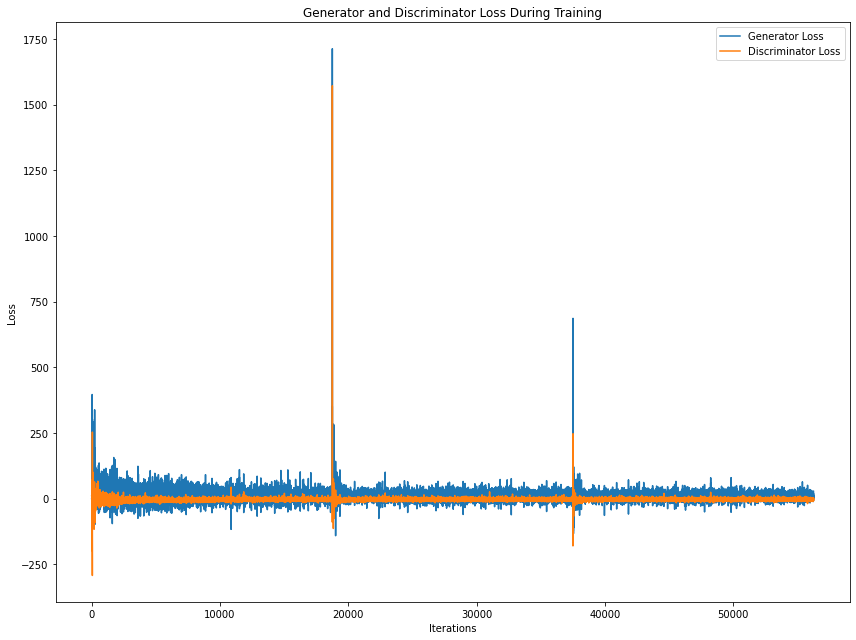

In [11]:
plot_losses_gan(gen_losses,dis_losses)

## VISUALIZE THE GENERATED DATA

#### Sample images from the generator.

Parameters:

`nb_samples:` The number of samples to generate

`num_classes:` Number of classes in dataset (optional)

`real_image_a:` Real image in subset_a (optional)

`real_image_b:` Real image in subset_b (optional)

Returns:

`img_list:` A list of generated images

In [12]:
img_list = gan.generate_samples(
    nb_samples = 36,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

#### Plots images

Plot a number of generated images with optional label

Parameters:

`img_list:` A list of generated images (Torch tensor)

`number:` Number of images we want to plot

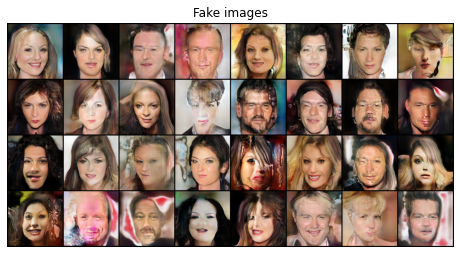

In [13]:
plot_image(img_list, number=32)